In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchensemble import VotingRegressor
import matplotlib.pyplot as plt
from modeling import Imager, InitialBeam, QuadScanTransport

all_k = torch.load("kappa.pt")
all_images = torch.load("images.pt").unsqueeze(1)
bins = torch.load("bins.pt")

bins = (bins[:-1] + bins[1:])/2
xx = torch.meshgrid(bins, bins)

all_k = all_k.cpu()
all_images = all_images.cpu()


# create data loader
class ImageDataset(Dataset):
    def __init__(self, k, images):
        self.images = images
        self.k = k

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.k[idx], self.images[idx]


class QuadScanModel(torch.nn.Module):
    def __init__(self, initial_beam, transport, imager):
        super(QuadScanModel, self).__init__()
        self.beam_generator = initial_beam
        self.lattice = transport
        self.imager = imager

    def forward(self, K):
        initial_beam = self.beam_generator()
        output_beam = self.lattice(initial_beam, K)
        output_coords = torch.cat(
            [output_beam.x.unsqueeze(0), output_beam.y.unsqueeze(0)]
        )
        output_images = self.imager(output_coords)
        return output_images

train_dset = torch.load("train.dset")
test_dset = torch.load("test.dset")

train_dataloader = DataLoader(train_dset, batch_size=2)
test_dataloader = DataLoader(test_dset)


bandwidth = torch.tensor(1.0e-4)

defaults = {
    "s": torch.tensor(0.0).float(),
    "p0c": torch.tensor(10.0e6).float(),
    "mc2": torch.tensor(0.511e6).float(),
}

module_kwargs = {
    "initial_beam": InitialBeam(100000, n_hidden=2, width=200, **defaults),
    "transport": QuadScanTransport(torch.tensor(0.1), torch.tensor(1.0)),
    "imager": Imager(bins, bandwidth)
}


ensemble = VotingRegressor(
    estimator=QuadScanModel,
    estimator_args=module_kwargs,
    n_estimators=1,
    n_jobs=1
)

class CustomLoss(torch.nn.MSELoss):
    pass


criterion = torch.nn.MSELoss(reduction="sum")
#criterion = CustomLoss()
ensemble.set_criterion(criterion)

ensemble.set_optimizer(
    "Adam",
    lr=0.01
)

from torchensemble.utils import io
io.load(ensemble, ".")
ensemble.cpu();

C:\ProgramData\Miniconda3\envs\phase_space_reconstruction\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


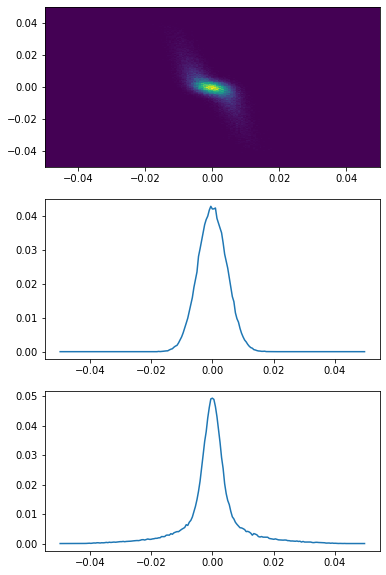

In [2]:
def calc_rms_size(xxx, images):
    # note image sums are normalized to 1

    fig,ax = plt.subplots(3,1)
    fig.set_size_inches(6,10)
    ax[0].pcolor(*xxx, images[-1,0])

    xx_ = xxx[0].unsqueeze(0).unsqueeze(0).repeat(*images.shape[:2], 1, 1)
    yy_ = xxx[1].unsqueeze(0).unsqueeze(0).repeat(*images.shape[:2], 1, 1)
    proj_x = images.sum(dim=-1)
    proj_y = images.sum(dim=-2)

    x = xx_[...,:,0]
    y = yy_[...,0,:]

    ax[1].plot(x[-1,0], proj_x[-1,0])
    ax[2].plot(y[-1,0], proj_y[-1,0])


    mean_x = torch.sum(x * proj_x, dim=-1).unsqueeze(-1)
    mean_y = torch.sum(y * proj_y, dim=-1).unsqueeze(-1)

    var_x = torch.sum((x - mean_x)**2 * proj_x, dim=-1).unsqueeze(-1)
    var_y = torch.sum((y - mean_y)**2 * proj_y, dim=-1).unsqueeze(-1)

    # calculate cross covariance
    #var_xy = torch.sum((xx_ - mean_x)*(yy_ - mean_y)*images, dim=-1).unsqueeze(-1)

    return torch.cat([mean_x, mean_y], dim=-1), torch.cat([var_x, var_y], dim=-1)

means, variances = calc_rms_size(xx, all_images)


In [3]:
train_k = all_k[train_dset.indices]
train_k = train_k.cpu()

train_im = all_images[train_dset.indices]
train_im = train_im.cpu()

test_k = all_k[test_dset.indices]
test_k = test_k.cpu()

test_im = all_images[test_dset.indices]
test_im = test_im.cpu()
print(all_images.shape)

torch.Size([20, 1, 199, 199])


In [4]:
recompute_images = False
with torch.no_grad():
    if recompute_images:
        dist = torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6))
        custom_beam = None#dist.sample([100000]).cuda()

        model_pred = torch.cat(
            [ensemble[i](all_k[:,:1]).unsqueeze(0) for i in range(len(ensemble))]
        )
        model_pred = torch.transpose(model_pred.squeeze(dim=2), 0,1)
        model_pred = model_pred.cpu().detach()

        torch.save(model_pred, "all_pred_images.pt")
    else:
        model_pred = torch.load("all_pred_images.pt")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor([ 2.2617e-07, -1.2572e-07]) tensor([0.0047, 0.0087])
tensor([-2.3969e-05,  8.0145e-05]) tensor([0.0045, 0.0077])
torch.Size([20, 1, 199, 199])
torch.Size([20, 1, 199, 199])


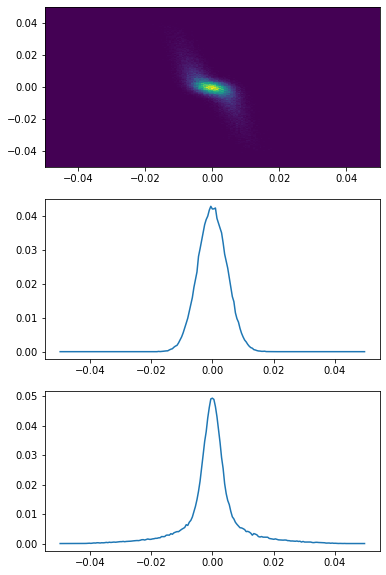

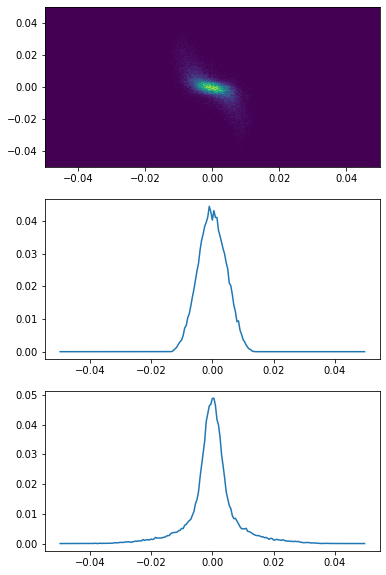

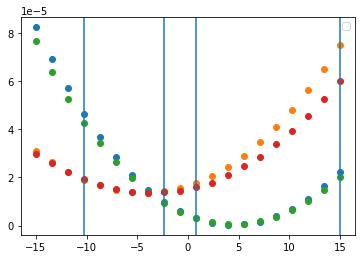

In [5]:
means, variances = calc_rms_size(xx, all_images)
pmeans, pvariances = calc_rms_size(xx, model_pred)

print(means[-1,0], variances[-1,0].sqrt())
print(pmeans[-1,0], pvariances[-1,0].sqrt())


fig,ax = plt.subplots()
k = all_k[:, 0]
#mean_variance = torch.mean(variances, dim=-2)
#error_variance = torch.std(variances, dim=-2)

ax.plot(k, variances[...,0],'o')
ax.plot(k, variances[...,1],'o')

#ax.errorbar(k, mean_variance[...,0], error_variance[...,0],capsize=5,ls='',
# label="true_x")
#ax.errorbar(k, mean_variance[...,1], error_variance[...,1],capsize=5,ls='',
# label="true_y")

print(model_pred.shape)
print(all_images.shape)

mean_pvariance = torch.mean(pvariances, dim=-2)
error_pvariance = torch.std(pvariances, dim=-2)

ax.plot(k, pvariances[...,0],'o')
ax.plot(k, pvariances[...,1],'o')

#ax.errorbar(k, mean_pvariance[...,0], error_pvariance[...,0],capsize=5,ls='', label="pred_x")
#ax.errorbar(k, mean_pvariance[...,1], error_pvariance[...,1],capsize=5,ls='',
# label="pred_y")

for ele in test_dset.indices:
    ax.axvline(all_k[ele,0])

ax.legend()

torch.Size([20, 1, 199, 199])


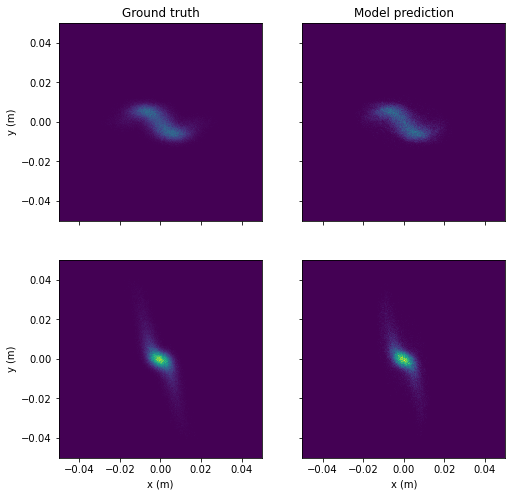

In [6]:
from visualization import compare_images
print(all_images.shape)
image_slice = [1,-1]
fig = compare_images(xx, model_pred.mean(dim=1)[image_slice], all_images.mean(dim=1)[image_slice])
#fig = compare_images(xx, model_pred[:6,0], all_images[:6,0])
fig.set_size_inches(8,8)

torch.Size([20, 1, 199, 199])
torch.Size([20, 1, 199, 199])


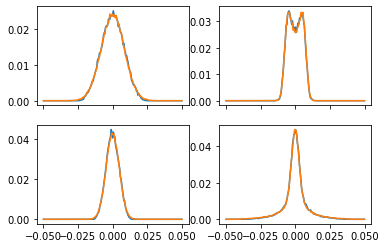

In [7]:
from visualization import compare_image_projections
print(all_images.shape)
print(model_pred.shape)

fig = compare_image_projections(xx[0].T[0], model_pred[image_slice], all_images[image_slice])


In [8]:
# compare initial beam distributions
from torch_track import Beam
defaults = {
    "s": torch.tensor(0.0).float(),
    "p0c": torch.tensor(10.0e6).float(),
    "mc2": torch.tensor(0.511e6).float(),
}

gt_initial_beam = torch.load("ground_truth_dist.pt")
gt_initial_beam = Beam(gt_initial_beam, **defaults)

# generate beams from model
pred_initial_beams = [ele.beam_generator() for ele in ensemble]
len(pred_initial_beams)

1

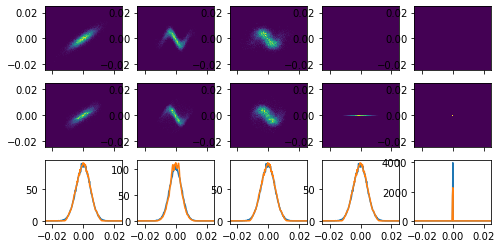

In [9]:
from visualization import add_image, add_projection
pairs = [["x","y"],["y","py"],["x", "py"],["x", "pz"],["z", "pz"]]
fig,ax = plt.subplots(3,len(pairs), sharex="all")#,sharey="row")
fig.set_size_inches(8,4)

plot_bins = bins / 2

for i, pair in enumerate(pairs):
    add_image(ax[0][i], *pair, [gt_initial_beam], plot_bins)
    add_image(ax[1][i], *pair, pred_initial_beams, plot_bins)

    add_projection(ax[2][i], pair[0], [gt_initial_beam], plot_bins)
    add_projection(ax[2][i], pair[0], pred_initial_beams, plot_bins)


0.027785811005528554
0.019873365083039607
0.028032049822965255


Text(0, 0.5, 'density')

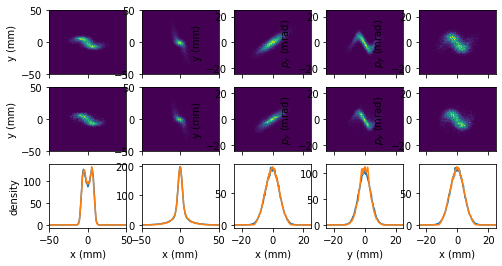

In [10]:
from visualization import add_image, add_projection, add_image_projection
import numpy as np
pairs = [["x","y"],["y","yp"],["x", "yp"]]
fig,ax = plt.subplots(3,len(pairs)+2, sharex="col")#,sharey="row")
fig.set_size_inches(8,4)

plot_bins = bins / 2
#plot_bins = plot_bins * 1e3

for g, pair in enumerate(pairs):
    i = g + 2
    _, gt_image = add_image(ax[0][i], *pair, [gt_initial_beam], plot_bins,
                            scale_axis=1e3)
    _, pred_image = add_image(ax[1][i], *pair, pred_initial_beams, plot_bins,
                           scale_axis=1e3)

    # calculate rms error
    rms_error = np.sqrt(((gt_image - pred_image)**2).sum() / gt_image.size)
    print(rms_error / np.max(gt_image))

    if pair[-1]=="y":
        ax[0][i].set_ylabel(pair[-1] + " (mm)")
        ax[1][i].set_ylabel(pair[-1] + " (mm)")
    elif pair[-1]=="yp":
        ax[0][i].set_ylabel("$p_y$ (mrad)")
        ax[1][i].set_ylabel("$p_y$ (mrad)")

    add_projection(ax[2][i], pair[0], [gt_initial_beam], plot_bins,scale_axis=1e3)
    add_projection(ax[2][i], pair[0], pred_initial_beams, plot_bins,scale_axis=1e3)

    ax[2][i].set_xlabel(pair[0] + " (mm)")

idxs = [0,-1]

for j, idx in enumerate(idxs):

    ax[0][j].pcolor(xx[0]*1e3,xx[1]*1e3, all_images[idx,0])
    ax[1][j].pcolor(xx[0]*1e3,xx[1]*1e3, model_pred[idx,0])

    ax[0][j].collections[0].set_rasterized(True)

    for ele in [all_images, model_pred]:
        proj = ele[idx,0].sum(dim=0)
        proj = proj / (proj.sum()*(plot_bins[-1]- plot_bins[-2]))

        ax[2,j].plot(plot_bins*1e3*2, proj)

# set rasterization for pcolor
for k in range(ax.shape[-1]):
    ax[0,k].collections[0].set_rasterized(True)
    ax[1,k].collections[0].set_rasterized(True)

ax[-1,0].set_xlabel('x (mm)')
ax[-1,1].set_xlabel('x (mm)')

ax[0,0].set_ylabel('y (mm)')
ax[1,0].set_ylabel('y (mm)')
ax[2,0].set_ylabel('density')

#fig.savefig("testfig.svg")

In [37]:
# calculate the covariances
#torch.cov(gt_initial_beam.data.T)[:2,:2].det().sqrt()
torch.cov(gt_initial_beam.data.T)[:4,:4].det().sqrt().sqrt()

tensor(3.7037e-06, dtype=torch.float64)

In [38]:
#torch.cov(pred_initial_beams[0].data.T)[:2,:2].det().sqrt()
torch.cov(pred_initial_beams[0].data.T)[:4,:4].det().sqrt().sqrt()

tensor(4.2303e-06, grad_fn=<SqrtBackward0>)